### Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [794]:
import pandas as pd 
#import matplotlib as plt
import numpy as np
import sklearn as sk 
import psycopg2 as psy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

#### Step 2: Examine your data 

In [795]:
#read in the airport cancellations file
df_raw = pd.read_csv("../assets/airport_cancellations.csv")
df = df_raw.dropna() 
df.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004,242,235,71,46
1,ABQ,2005,221,190,61,33
2,ABQ,2006,392,329,71,124
3,ABQ,2007,366,304,107,45
4,ABQ,2008,333,300,79,42


### Intro: Write a problem statement / aim for this project

I am an individual consultant hired by the FAA. FAA wants to organize their airport cancellation data so they can easily understand it. They want me to mine and refine the data to uncover its basic attributes and characteristics. I need to figure out which operational characteristics affect the delays/cancellations the most at which airports.

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [796]:
!postgres -D /usr/local/pgsql/data >logfile 2>&1 
#!brew services restart postgresql
!createdb mydb

createdb: database creation failed: ERROR:  database "mydb" already exists


Load our csv files into tables

In [797]:
df.columns = [c.lower() for c in df.columns] #postgres doesn't like capitals or spaces so lower case them

#use sqlalchemy to create an engine
from sqlalchemy import create_engine
engine = create_engine('postgresql://:@localhost:5432/mydb')

#this was use to create a table1. Table1 is airport cancellations data.
#df.to_sql("table1", engine)

df1 = pd.read_csv('../assets/airports.csv')
df1.columns = [c.lower() for c in df1.columns] #postgres doesn't like capitals or spaces so lower case them

#this was use to create table2. Table 2 is a list of airports and its locations.
#df1.to_sql("table2", engine)


df2 = pd.read_csv('../assets/Airport_operations.csv')
#df2.to_sql('table3',engine) #Table3 is data on airport operations

Join airport_cancellations.csv and airports.csv into one table

In [798]:
#join airport cancellations and airport table together
joinedTable = pd.read_sql("SELECT * FROM table1 a JOIN table2 b ON a.Airport=b.LocID;",con=engine)
#joinedTable1.to_csv('../assets/joinedTable.csv',encoding='utf-8')

#join airport cancellations and airport operations together
joinedTable1 = pd.read_sql("SELECT * FROM table1 a JOIN table3 c on a.Airport=c.airport AND a.year=c.year;",con=engine)
#joinedTable1.shape
#joinedTable1.to_csv('../assets/joinedtable1.csv',encoding='utf-8')


Query the database for our intial data

In [799]:
#drop unnecessary columns
joinedTable.drop(['index','index','locid','facility type','key','alias'],axis=1,inplace=True)
joinedTable.head(20)

,airport,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,ap_name,faa region,county,city,state,ap type,latitude,longitude,boundary data available
0,ABQ,2004.0,242.0,235.0,71.0,46.0,ALBUQUERQUE INTL SUNPORT,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
1,ABQ,2005.0,221.0,190.0,61.0,33.0,ALBUQUERQUE INTL SUNPORT,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
2,ABQ,2006.0,392.0,329.0,71.0,124.0,ALBUQUERQUE INTL SUNPORT,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
3,ABQ,2007.0,366.0,304.0,107.0,45.0,ALBUQUERQUE INTL SUNPORT,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
4,ABQ,2008.0,333.0,300.0,79.0,42.0,ALBUQUERQUE INTL SUNPORT,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
5,ABQ,2009.0,192.0,162.0,74.0,26.0,ALBUQUERQUE INTL SUNPORT,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
6,ABQ,2010.0,222.0,177.0,71.0,50.0,ALBUQUERQUE INTL SUNPORT,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
7,ABQ,2011.0,345.0,294.0,77.0,61.0,ALBUQUERQUE INTL SUNPORT,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
8,ABQ,2012.0,237.0,181.0,65.0,60.0,ALBUQUERQUE INTL SUNPORT,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
9,ABQ,2013.0,232.0,212.0,62.0,46.0,ALBUQUERQUE INTL SUNPORT,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes


In [800]:
#save columns that you don't want to drop
airportList = joinedTable1['airport']
yearList = joinedTable1['year']

#drop all columns that I don't need
joinedTable1.drop(['index','index','airport','year'],axis=1,inplace=True)

#add the columns back to the dataframe
joinedTable1['airport'] = airportList.ix[:,0]
joinedTable1['year'] = yearList.ix[:,0]

#shift the columns
cols = joinedTable1.columns.tolist()
cols = cols[-2:] + cols[:-2]
joinedTable1 = joinedTable1[cols]
        
joinedTable1.head()


,airport,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


#### 1.2 What are the risks and assumptions of our data? 

There might be data for certain airports. User input error.

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [801]:
joinedTable.describe()


,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,latitude,longitude
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,2008.986335,1292.038509,1333.124224,173.315528,169.413665,36.447419,-95.079989
std,3.158116,1835.961943,1975.224868,172.345539,228.521615,6.665118,20.673725
min,2004.000000,0.000000,0.000000,0.000000,0.000000,18.439295,-157.922429
25%,2006.000000,349.000000,314.000000,62.000000,41.000000,32.896828,-112.011583
50%,2009.000000,663.000000,642.000000,110.000000,84.000000,37.618972,-87.897068
75%,2012.000000,1472.000000,1523.000000,236.000000,190.000000,40.795250,-80.152741
max,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000,61.174083,-66.002004


In [802]:
joinedTable1.describe()

,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,2009.016270,1299.314143,1341.068836,174.250313,170.256571,113471.568210,113003.959950,0.779123,0.726958,0.766864,12.890250,13.872879,3.683292,15.703504,2.875532,1.414155,3.290826,13.428811
std,3.150126,1840.877193,1980.459892,172.638408,229.162686,98059.144667,97705.308115,0.052279,0.076027,0.050502,3.036474,3.806217,2.337325,4.364217,1.169739,0.854702,0.989275,3.251647
min,2004.000000,0.000000,0.000000,0.000000,0.000000,731.000000,717.000000,0.529900,0.380800,0.513600,5.350000,7.240000,0.100000,6.290000,0.950000,0.020000,1.330000,6.330000
25%,2006.000000,349.000000,314.500000,62.000000,41.000000,42064.000000,42006.500000,0.753100,0.691800,0.742150,10.830000,11.475000,2.300000,12.890000,2.035000,0.845000,2.615000,11.270000
50%,2009.000000,670.000000,653.000000,111.000000,84.000000,79489.000000,79750.000000,0.784100,0.740200,0.770500,12.540000,12.940000,3.050000,15.130000,2.620000,1.140000,3.130000,12.970000
75%,2012.000000,1483.500000,1542.000000,237.000000,190.000000,166469.500000,165560.500000,0.810700,0.773700,0.797600,14.620000,15.745000,4.220000,17.555000,3.550000,1.775000,3.815000,14.935000
max,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000,491826.000000,486799.000000,0.909700,0.897400,0.880300,25.840000,35.760000,18.940000,40.510000,7.820000,6.180000,7.520000,27.780000


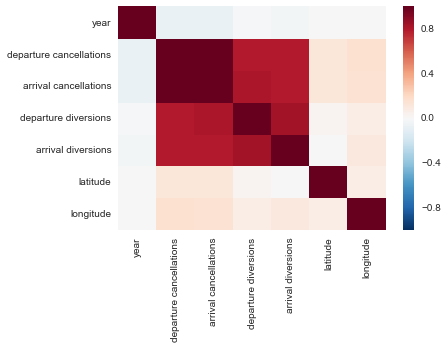

In [803]:
sns.heatmap(joinedTable.corr())

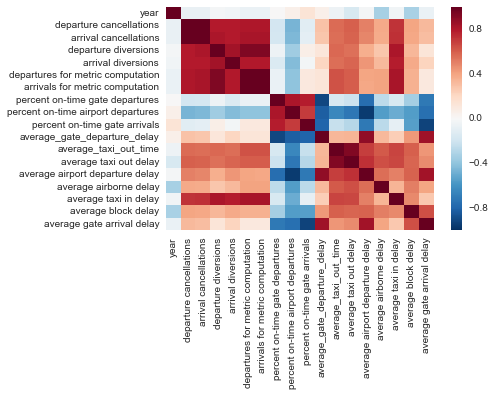

In [804]:
sns.heatmap(joinedTable1.corr())

In [805]:
joinedTable1.head()

,airport,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


#### Are there any unique values? 

In [806]:
print (joinedTable['ap_name'].unique())
#(joinedTable['airport'].unique())
print joinedTable1['airport'].unique()
#len(joinedTable['airport'].value_counts())

[u'ALBUQUERQUE INTL SUNPORT' u'TED STEVENS ANCHORAGE INTL'
 u'HARTSFIELD - JACKSON ATLANTA INTL' u'AUSTIN-BERGSTROM INTL'
 u'BRADLEY INTL' u'BIRMINGHAM-SHUTTLESWORTH INTL' u'NASHVILLE INTL'
 u'GENERAL EDWARD LAWRENCE LOGAN INTL' u'BUFFALO NIAGARA INTL' u'BOB HOPE'
 u'BALTIMORE/WASHINGTON INTL THURGOOD MARSHAL' u'CLEVELAND-HOPKINS INTL'
 u'CHARLOTTE/DOUGLAS INTL' u'CINCINNATI/NORTHERN KENTUCKY INTL'
 u'DALLAS LOVE FIELD' u'JAMES M COX DAYTON INTL'
 u'RONALD REAGAN WASHINGTON NATIONAL' u'DENVER INTL'
 u'DALLAS/FORT WORTH INTL' u'DETROIT METROPOLITAN WAYNE COUNTY'
 u'NEWARK LIBERTY INTL' u'FORT LAUDERDALE/HOLLYWOOD INTL' u'HONOLULU INTL'
 u'WILLIAM P HOBBY' u'WESTCHESTER COUNTY' u'WASHINGTON DULLES INTL'
 u'GEORGE BUSH INTERCONTINENTAL/HOUSTON' u'INDIANAPOLIS INTL'
 u'LONG ISLAND MAC ARTHUR' u'JACKSONVILLE INTL' u'JOHN F KENNEDY INTL'
 u'MC CARRAN INTL' u'LOS ANGELES INTL' u'LA GUARDIA'
 u'LONG BEACH /DAUGHERTY FIELD/' u'KANSAS CITY INTL' u'ORLANDO INTL'
 u'CHICAGO MIDWAY INTL' u'MEMPHIS 

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [807]:
#create dummy variables
dummy_location = pd.get_dummies(joinedTable1['airport'], prefix='airport')

dummyDF = joinedTable1.join(dummy_location.ix[:, :])

#### 3.2 Format and Clean the Data

In [808]:
dummyDF.head()

,airport,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,...,airport_SFO,airport_SJC,airport_SJU,airport_SLC,airport_SMF,airport_SNA,airport_STL,airport_SWF,airport_TPA,airport_TUS
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [809]:
#change year column to int type
dummyDF['year'] = dummyDF['year'].astype(int)
dummyDF.head()

,airport,year,departure cancellations,arrival cancellations,departure diversions,arrival diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,...,airport_SFO,airport_SJC,airport_SJU,airport_SLC,airport_SMF,airport_SNA,airport_STL,airport_SWF,airport_TPA,airport_TUS
0,ABQ,2004,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABQ,2005,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ABQ,2006,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ABQ,2007,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ABQ,2008,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

In [810]:
#sns.pairplot(dummyDF.loc[:,:'average gate arrival delay'])
#pairplot is too large

#### 4.2 Find correlations in the data

In [811]:
#X is all the operational characteristics that causes delays
X = dummyDF.loc[:,'average_gate_departure_delay':'average gate arrival delay']
#y is the 3 letter airport codes
y = dummyDF.ix[:,0]
#standarize all the X
X_std = StandardScaler().fit_transform(X)

print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

#joinedTable1['airport'] = joinedTable1['airport'].astype('category')
#airport_cat = joinedTable1.select_dtypes(['category']).columns
#joinedTable1['airport_cat'] = joinedTable1[airport_cat].apply(lambda x: x.cat.codes)

NumPy covariance matrix: 
[[ 1.00125313  0.33219271  0.3394709   0.88759016  0.32849483  0.24938554
   0.43558082  0.85132463]
 [ 0.33219271  1.00125313  0.92451587  0.68933194  0.61263653  0.6776738
   0.60134422  0.44288896]
 [ 0.3394709   0.92451587  1.00125313  0.73444768  0.64371827  0.66649771
   0.58064526  0.47042832]
 [ 0.88759016  0.68933194  0.73444768  1.00125313  0.5554855   0.50475109
   0.58983426  0.83992778]
 [ 0.32849483  0.61263653  0.64371827  0.5554855   1.00125313  0.33999547
   0.51510905  0.39250349]
 [ 0.24938554  0.6776738   0.66649771  0.50475109  0.33999547  1.00125313
   0.48302507  0.26697459]
 [ 0.43558082  0.60134422  0.58064526  0.58983426  0.51510905  0.48302507
   1.00125313  0.64451137]
 [ 0.85132463  0.44288896  0.47042832  0.83992778  0.39250349  0.26697459
   0.64451137  1.00125313]]


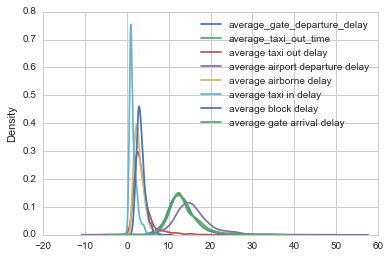

In [812]:
joinedTable1.head()

#density plot for the operation delays is the most frequent in average taxi in delay
joinedTable1.loc[:,"average_gate_departure_delay":"average gate arrival delay"].plot.density()

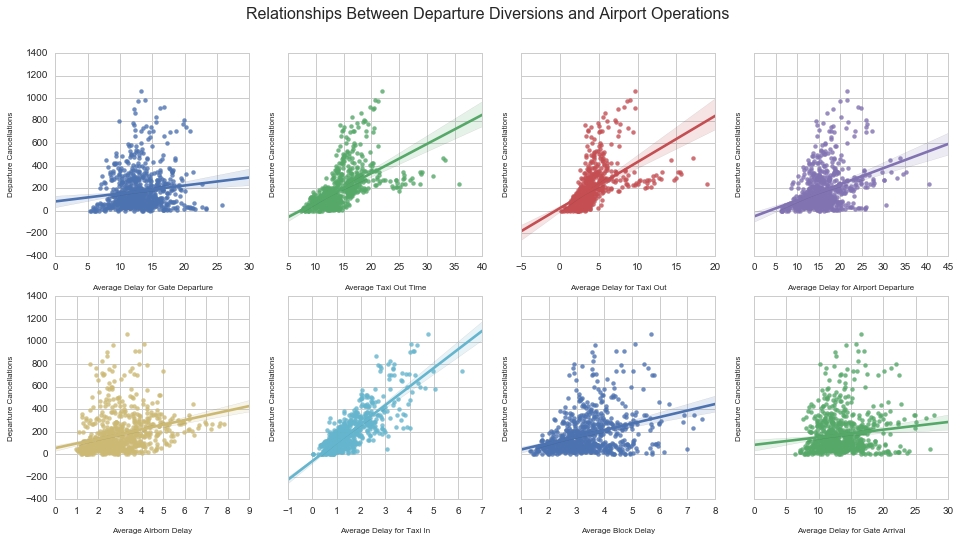

In [813]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(16, 8))
plt.suptitle("Relationships Between Departure Diversions and Airport Operations", size=16)

sns.set_style('whitegrid')
a = sns.regplot(x="average_gate_departure_delay", y="departure diversions", data=joinedTable1, ax=ax1)
ax1.set_xlabel("\nAverage Delay for Gate Departure",fontsize=8)
ax1.set_ylabel("Departure Cancellations\n",fontsize=8)

b = sns.regplot(x="average_taxi_out_time", y="departure diversions", data=joinedTable1, ax=ax2)
ax2.set_xlabel("\nAverage Taxi Out Time",fontsize=8)
ax2.set_ylabel("Departure Cancellations\n",fontsize=8)

c = sns.regplot(x="average taxi out delay", y="departure diversions", data=joinedTable1, ax=ax3)
ax3.set_xlabel("\nAverage Delay for Taxi Out",fontsize=8)
ax3.set_ylabel("Departure Cancellations\n",fontsize=8)

d = sns.regplot(x="average airport departure delay", y="departure diversions", data=joinedTable1, ax=ax4)
ax4.set_xlabel("\nAverage Delay for Airport Departure",fontsize=8)
ax4.set_ylabel("Departure Cancellations\n",fontsize=8)

e = sns.regplot(x="average airborne delay", y="departure diversions", data=joinedTable1, ax=ax5)
ax5.set_xlabel("\nAverage Airborn Delay",fontsize=8)
ax5.set_ylabel("Departure Cancellations\n",fontsize=8)

f = sns.regplot(x="average taxi in delay", y="departure diversions", data=joinedTable1, ax=ax6)
ax6.set_xlabel("\nAverage Delay for Taxi In",fontsize=8)
ax6.set_ylabel("Departure Cancellations\n",fontsize=8)

f = sns.regplot(x="average block delay", y="departure diversions", data=joinedTable1, ax=ax7)
ax7.set_xlabel("\nAverage Block Delay",fontsize=8)
ax7.set_ylabel("Departure Cancellations\n",fontsize=8)

f = sns.regplot(x="average gate arrival delay", y="departure diversions", data=joinedTable1, ax=ax8)
ax8.set_xlabel("\nAverage Delay for Gate Arrival",fontsize=8)
ax8.set_ylabel("Departure Cancellations\n",fontsize=8)


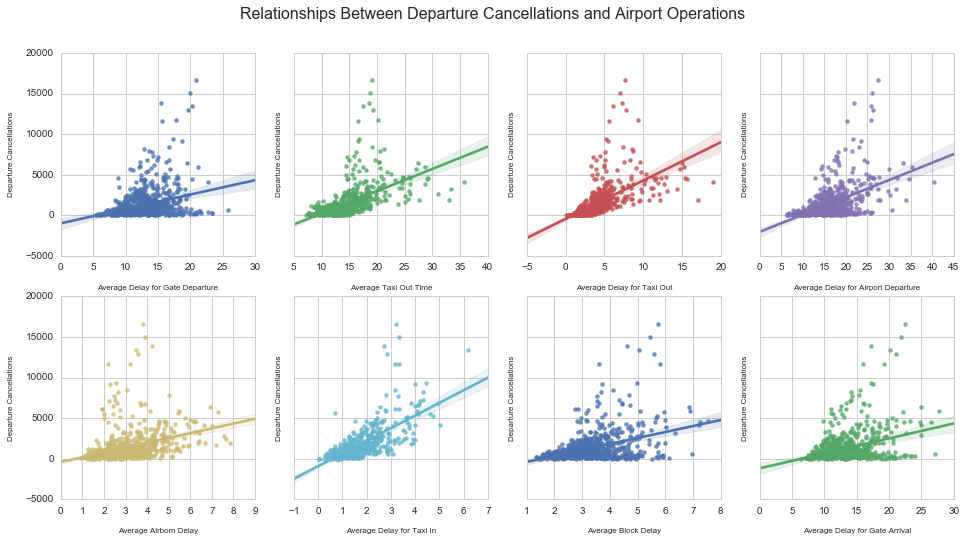

In [814]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(16, 8))
plt.suptitle("Relationships Between Departure Cancellations and Airport Operations", size=16)

sns.set_style('whitegrid')
a = sns.regplot(x="average_gate_departure_delay", y="departure cancellations", data=joinedTable1, ax=ax1)
ax1.set_xlabel("\nAverage Delay for Gate Departure",fontsize=8)
ax1.set_ylabel("Departure Cancellations\n",fontsize=8)

b = sns.regplot(x="average_taxi_out_time", y="departure cancellations", data=joinedTable1, ax=ax2)
ax2.set_xlabel("\nAverage Taxi Out Time",fontsize=8)
ax2.set_ylabel("Departure Cancellations\n",fontsize=8)

c = sns.regplot(x="average taxi out delay", y="departure cancellations", data=joinedTable1, ax=ax3)
ax3.set_xlabel("\nAverage Delay for Taxi Out",fontsize=8)
ax3.set_ylabel("Departure Cancellations\n",fontsize=8)

d = sns.regplot(x="average airport departure delay", y="departure cancellations", data=joinedTable1, ax=ax4)
ax4.set_xlabel("\nAverage Delay for Airport Departure",fontsize=8)
ax4.set_ylabel("Departure Cancellations\n",fontsize=8)

e = sns.regplot(x="average airborne delay", y="departure cancellations", data=joinedTable1, ax=ax5)
ax5.set_xlabel("\nAverage Airborn Delay",fontsize=8)
ax5.set_ylabel("Departure Cancellations\n",fontsize=8)

f = sns.regplot(x="average taxi in delay", y="departure cancellations", data=joinedTable1, ax=ax6)
ax6.set_xlabel("\nAverage Delay for Taxi In",fontsize=8)
ax6.set_ylabel("Departure Cancellations\n",fontsize=8)

f = sns.regplot(x="average block delay", y="departure cancellations", data=joinedTable1, ax=ax7)
ax7.set_xlabel("\nAverage Block Delay",fontsize=8)
ax7.set_ylabel("Departure Cancellations\n",fontsize=8)

f = sns.regplot(x="average gate arrival delay", y="departure cancellations", data=joinedTable1, ax=ax8)
ax8.set_xlabel("\nAverage Delay for Gate Arrival",fontsize=8)
ax8.set_ylabel("Departure Cancellations\n",fontsize=8)


#### 4.3 What is the value of understanding correlations before PCA? 

In [815]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.31741981  0.55704783  0.13608519 -0.22513241  0.21626923  0.54642898
  -0.41606417 -0.03566783]
 [-0.3809979  -0.35307612  0.03024656 -0.13836081 -0.42019292 -0.01287077
  -0.27459213 -0.67675011]
 [-0.38716182 -0.33289753 -0.00967257 -0.21404127 -0.39758913  0.37844523
   0.20186803  0.59273023]
 [-0.41751215  0.23816752  0.0893608  -0.28365588 -0.02858357 -0.7468953
  -0.20018144  0.28595737]
 [-0.31239861 -0.18507186 -0.76180395 -0.15351701  0.49804978  0.00667011
   0.09892859 -0.07973607]
 [-0.29655475 -0.38490421  0.61676254  0.05286435  0.58321605  0.00110191
   0.19345102 -0.05610602]
 [-0.34614576 -0.0129385  -0.10775421  0.86640343 -0.03391845 -0.00855475
  -0.30011018  0.16266551]
 [-0.35287407  0.46359484  0.01161015  0.16395226 -0.16860129 -0.00757961
   0.73033566 -0.26771358]]

Eigenvalues 
[  4.95922040e+00   1.38424728e+00   6.52877457e-01   5.15645708e-01
   3.11456971e-01   1.20653638e-03   1.08593567e-01   7.67771384e-02]


In [816]:
cor_mat1 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.31741981  0.55704783  0.13608519 -0.22513241  0.21626923  0.54642898
  -0.41606417 -0.03566783]
 [-0.3809979  -0.35307612  0.03024656 -0.13836081 -0.42019292 -0.01287077
  -0.27459213 -0.67675011]
 [-0.38716182 -0.33289753 -0.00967257 -0.21404127 -0.39758913  0.37844523
   0.20186803  0.59273023]
 [-0.41751215  0.23816752  0.0893608  -0.28365588 -0.02858357 -0.7468953
  -0.20018144  0.28595737]
 [-0.31239861 -0.18507186 -0.76180395 -0.15351701  0.49804978  0.00667011
   0.09892859 -0.07973607]
 [-0.29655475 -0.38490421  0.61676254  0.05286435  0.58321605  0.00110191
   0.19345102 -0.05610602]
 [-0.34614576 -0.0129385  -0.10775421  0.86640343 -0.03391845 -0.00855475
  -0.30011018  0.16266551]
 [-0.35287407  0.46359484  0.01161015  0.16395226 -0.16860129 -0.00757961
   0.73033566 -0.26771358]]

Eigenvalues 
[  4.95301362e+00   1.38251481e+00   6.52060339e-01   5.15000344e-01
   3.11067163e-01   1.20502633e-03   1.08457655e-01   7.66810469e-02]


Answer: Reducing dimensionality.

#### 4.4 Validate your findings using statistical analysis

In [817]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
len(var_exp)

8

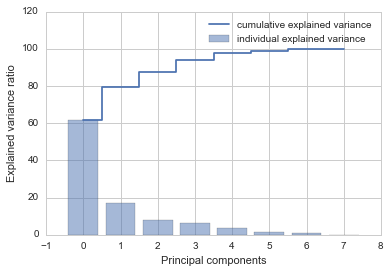

[  61.91267022   79.19410532   87.34485956   93.78236386   97.67070339
   99.02642408   99.98493717  100.        ]
[61.912670221067856, 17.281435101531695, 8.1507542356490674, 6.4375043016476212, 3.8883395315872122, 1.3557206931789201, 0.9585130862717115, 0.015062829065927891]


In [818]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    axes = plt.gca()
    axes.set_ylim([0,120])
    plt.bar(range(8), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(8), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.show()
    
print cum_var_exp
print var_exp

The plot above clearly shows that most of the variance (79.2% of the variance to be precise) can be explained by the first two principal components. The third principal component still bears some information (8.15%) while the fouth principal component consists of 6.43% and the fifth principal component consists of 3.89% of the varaince. So, everything but the first two components can be dropped.

#### 4.5 How can you improve your overall analysis? 

I could include more principal components.

### Part 5: Perform a PCA and Present Findings

#### 5.1 Conduct the PCA

In [819]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=5)
#pca.fit(joinedTable1.loc[:,'year'])
#pca.components_

#perform sci-kit PCA with 2 principal components
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)


In [820]:
uniqueNames = tuple(dummyDF.ix[:,0].unique())

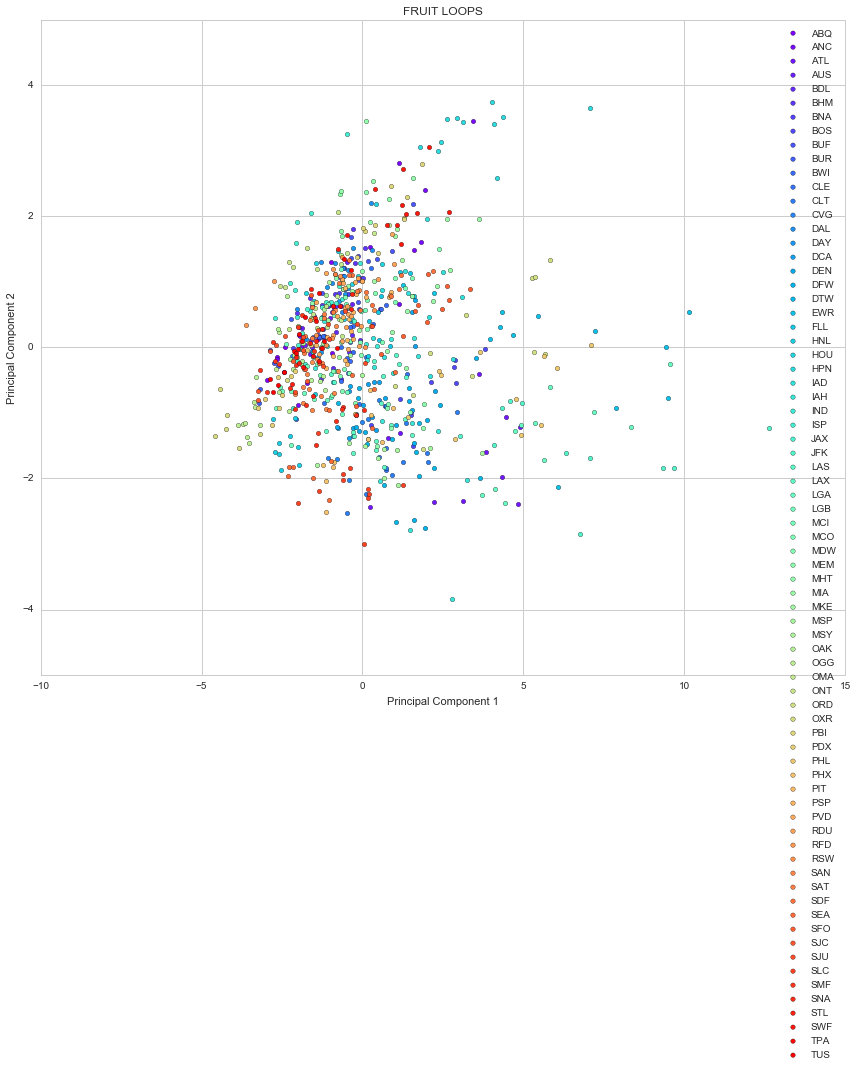

In [821]:
#create the plot for PCA
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(uniqueNames)))
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 10))
    for lab,c in zip(uniqueNames,colors):
        plt.scatter(Y_sklearn[np.array(y==lab), 0],
                    Y_sklearn[np.array(y==lab), 1],
                    label=lab,
                    c=c
                    )
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('FRUIT LOOPS')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
#FRUIT LOOPS

#### 5.2 Write an analysis plan of your findings 

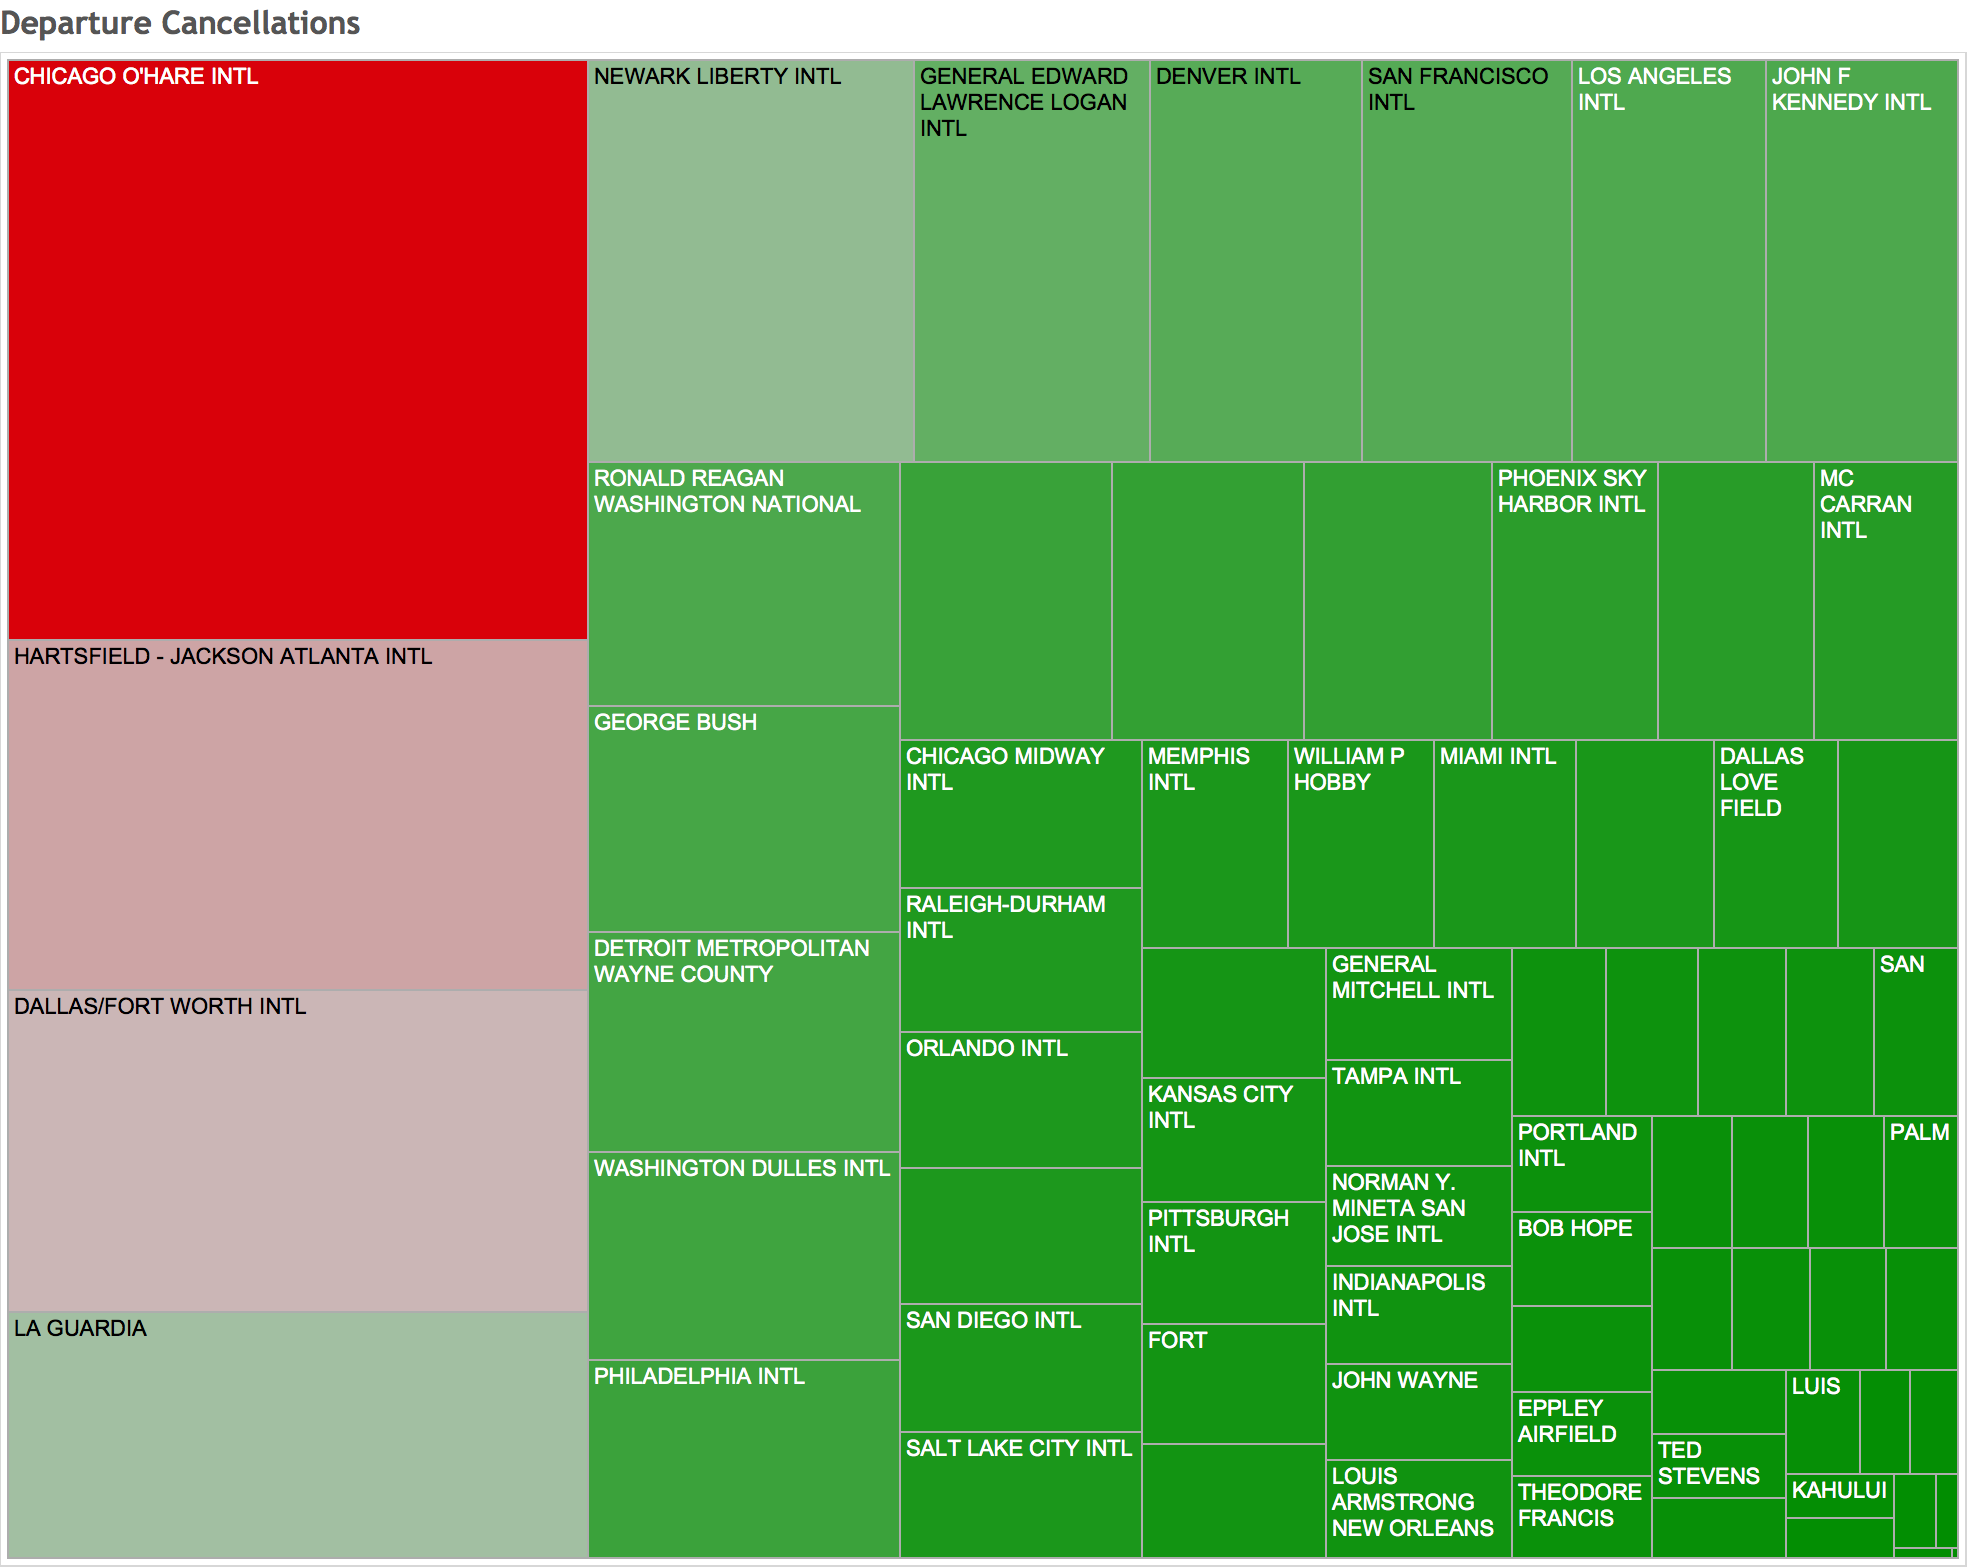

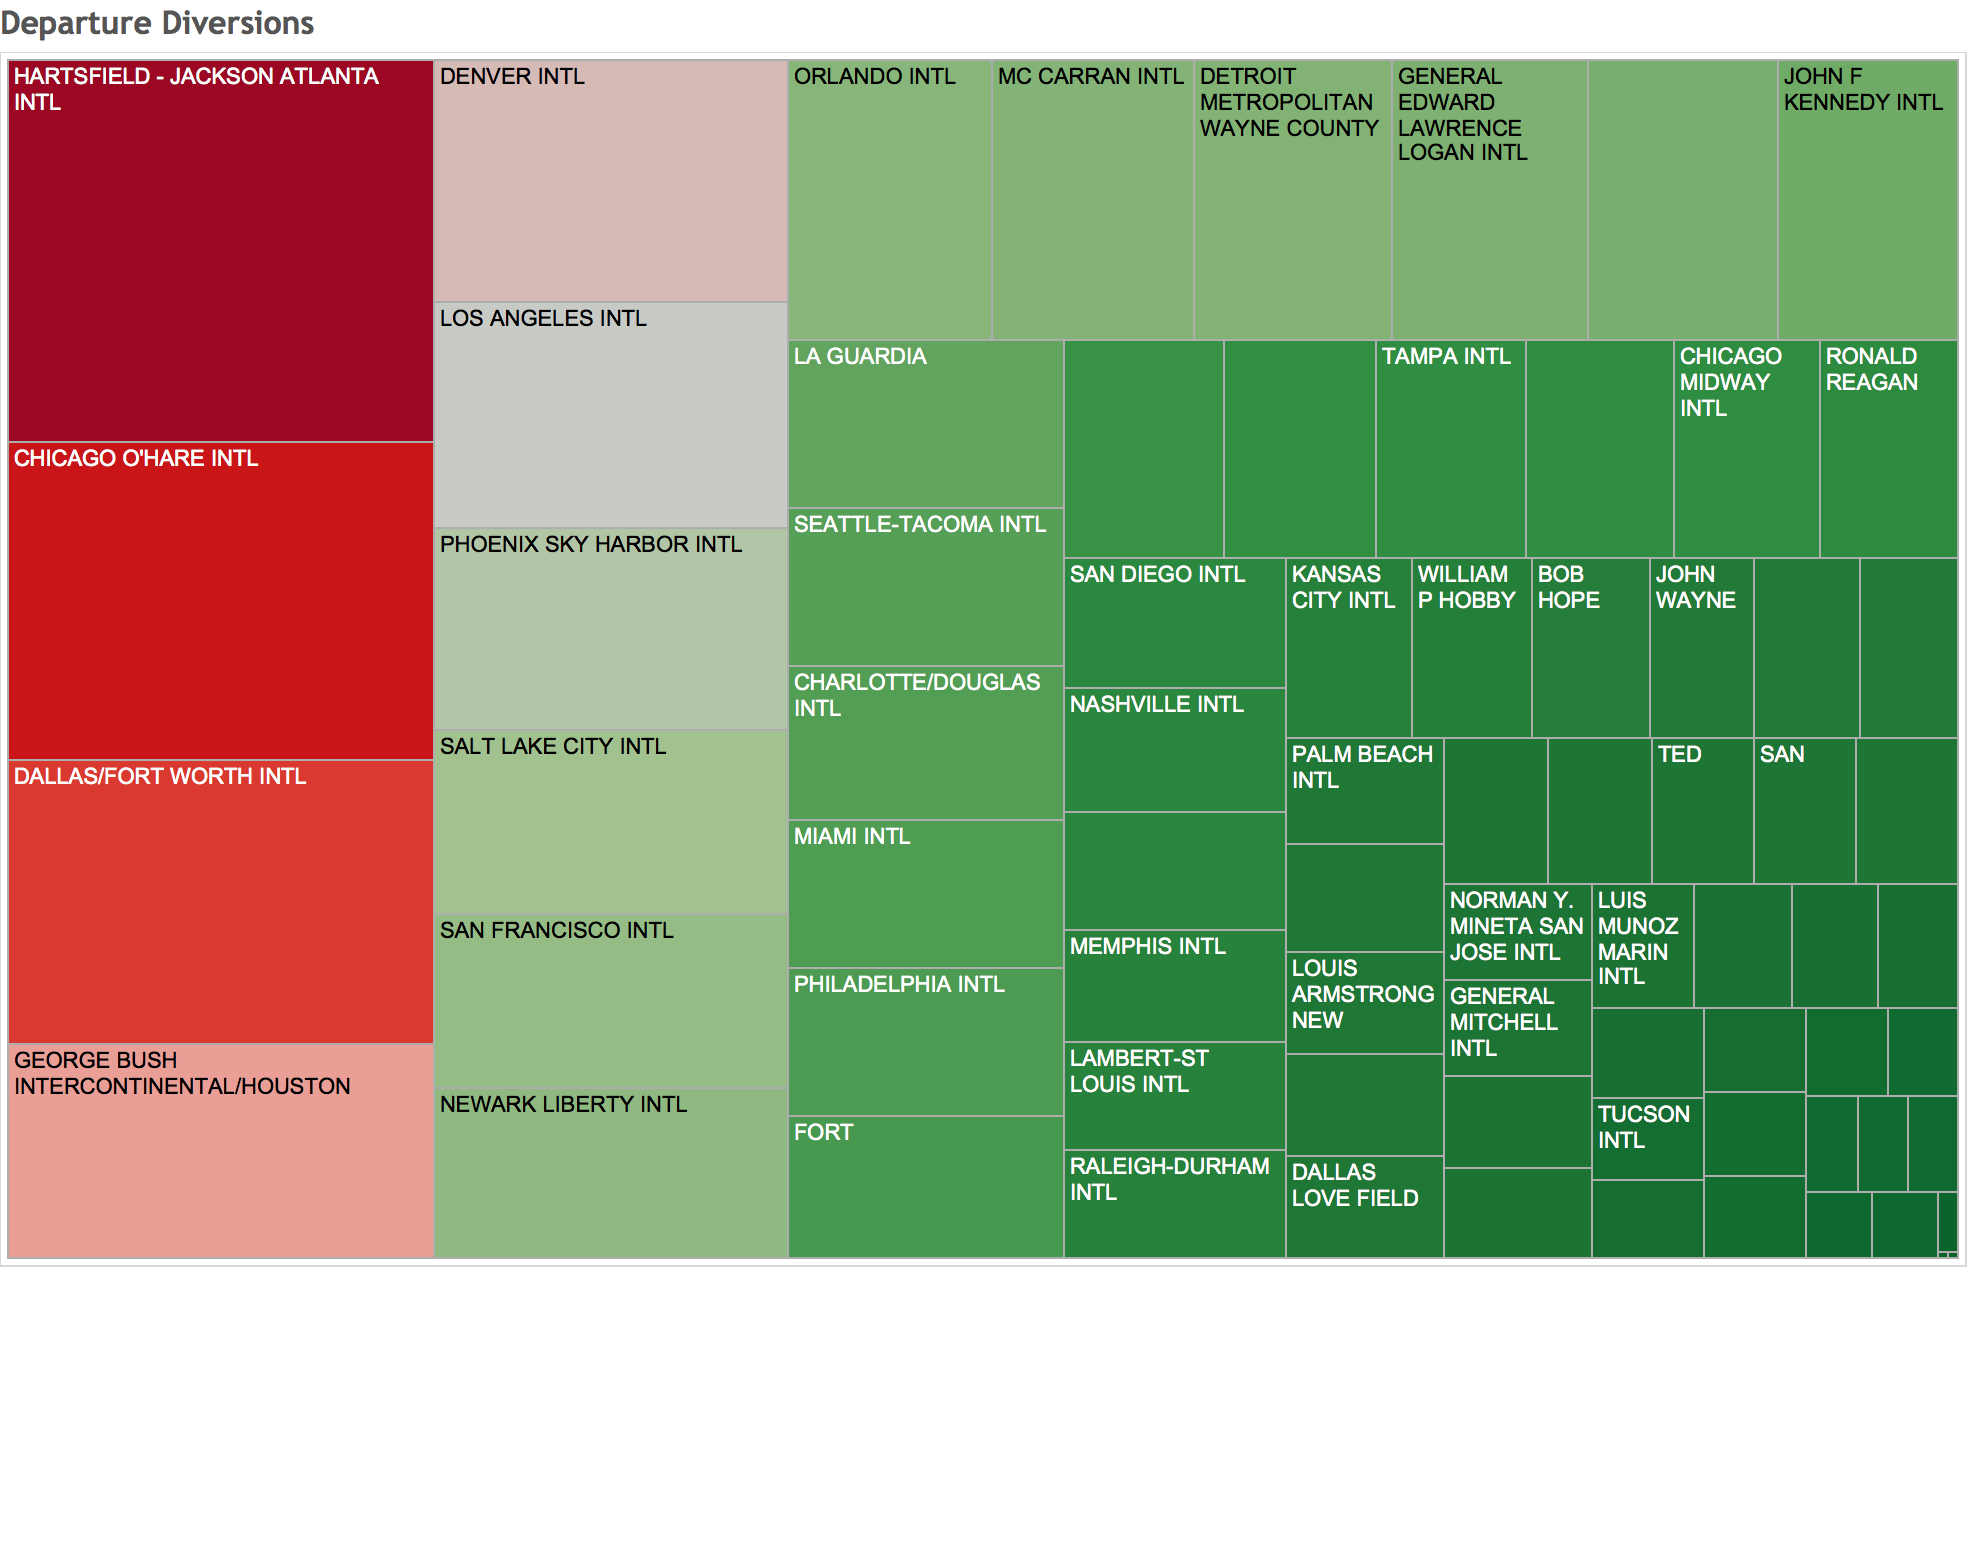

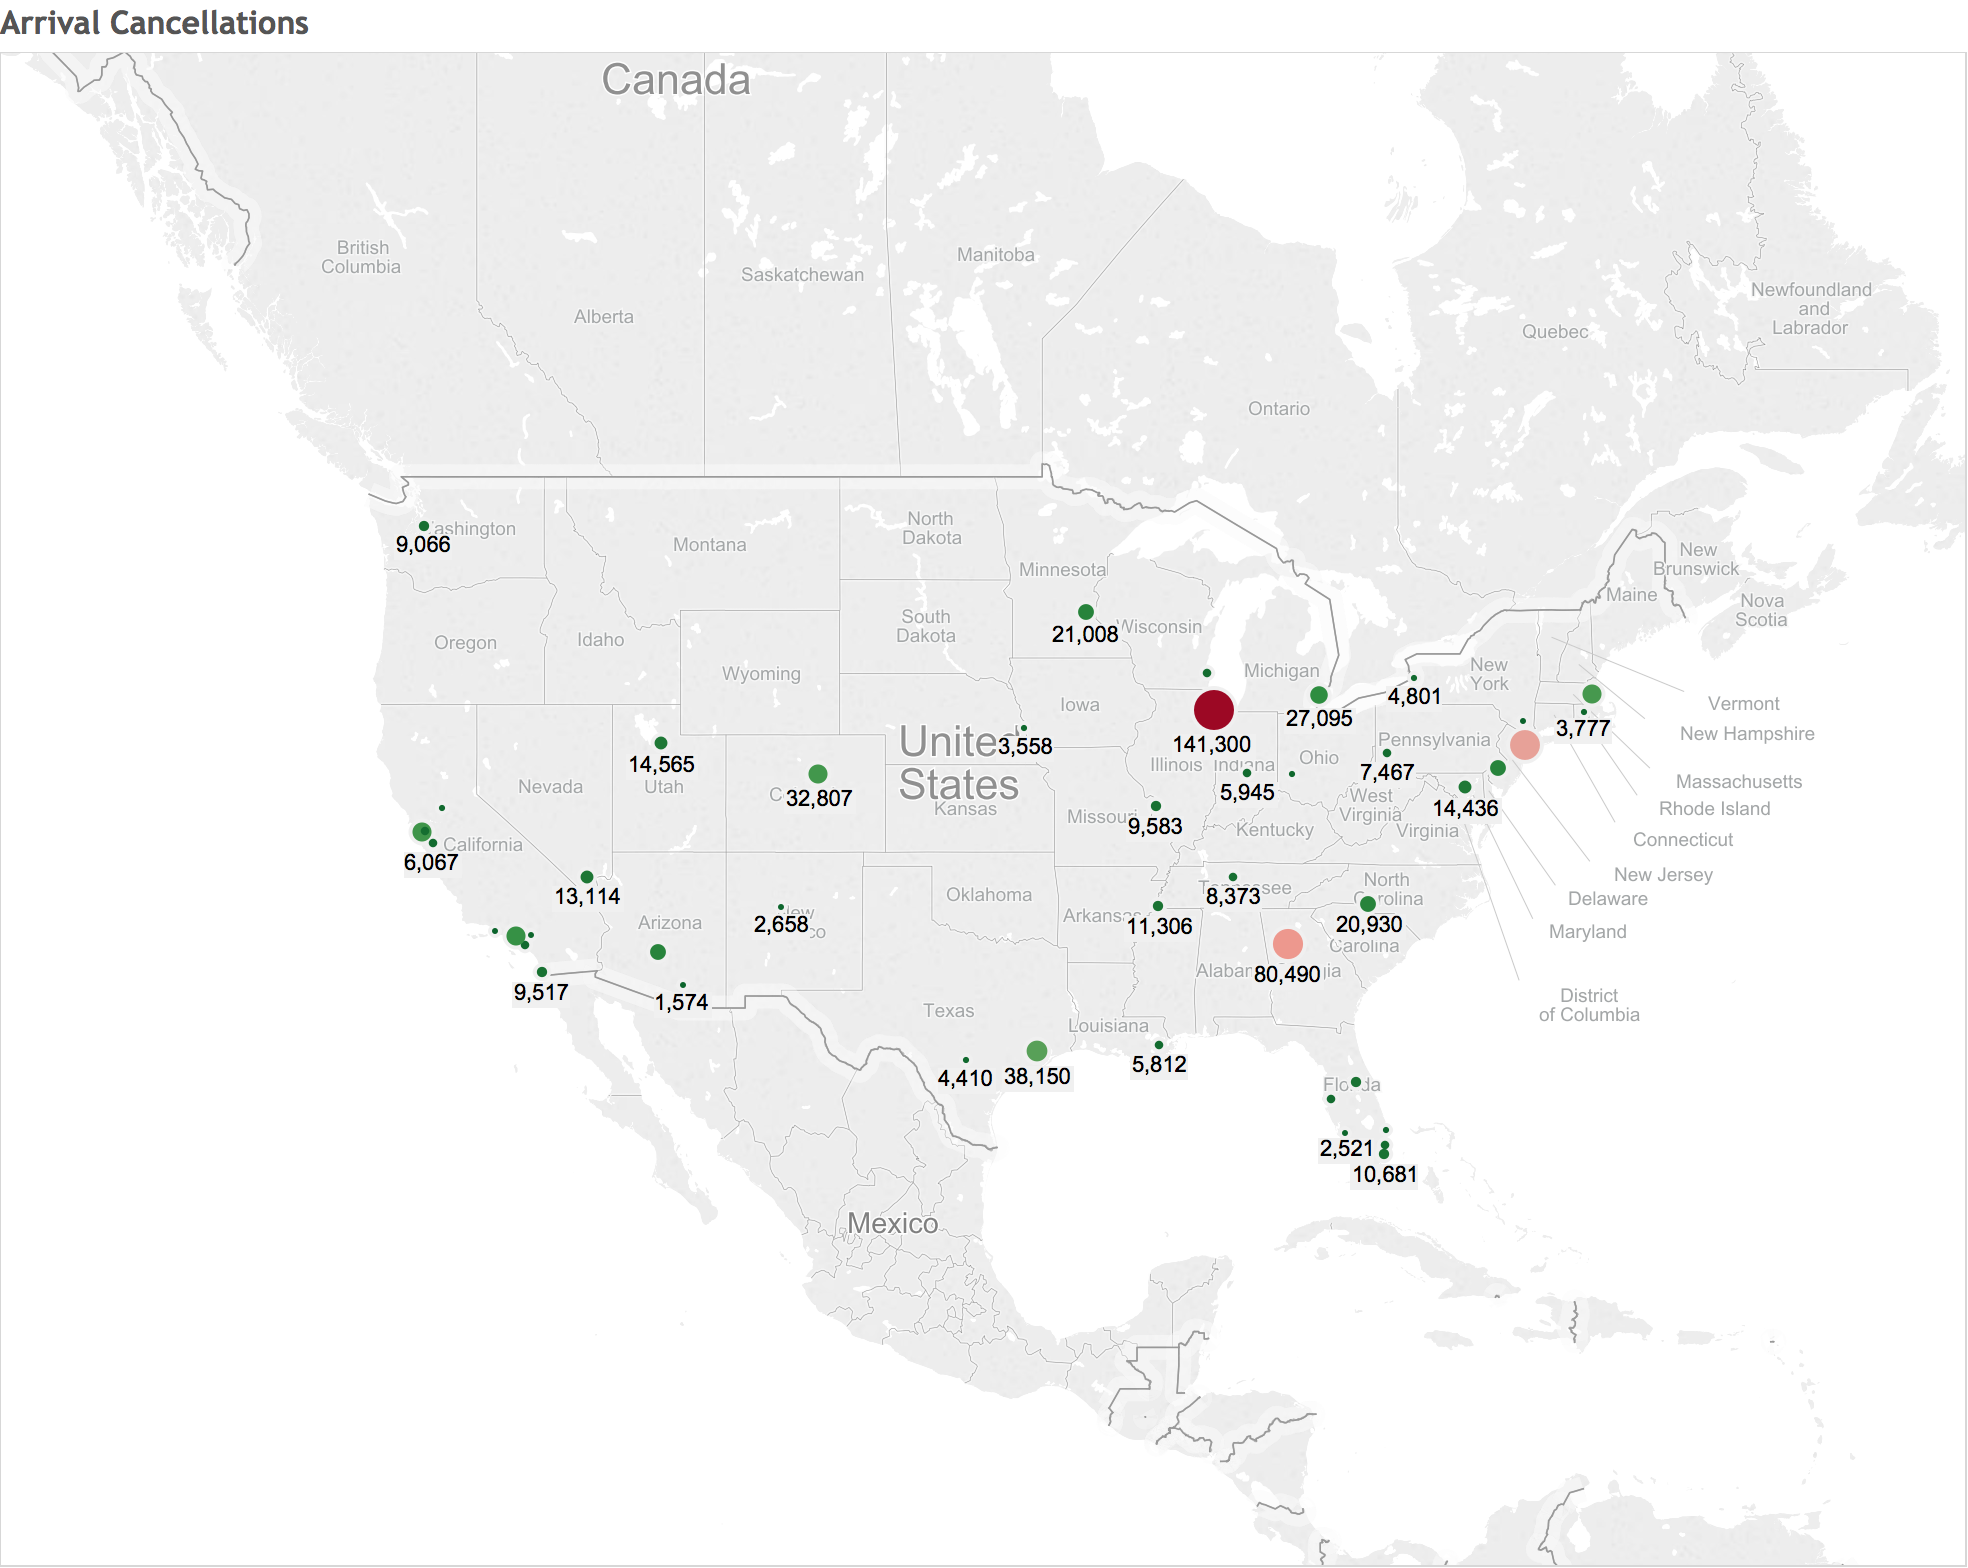

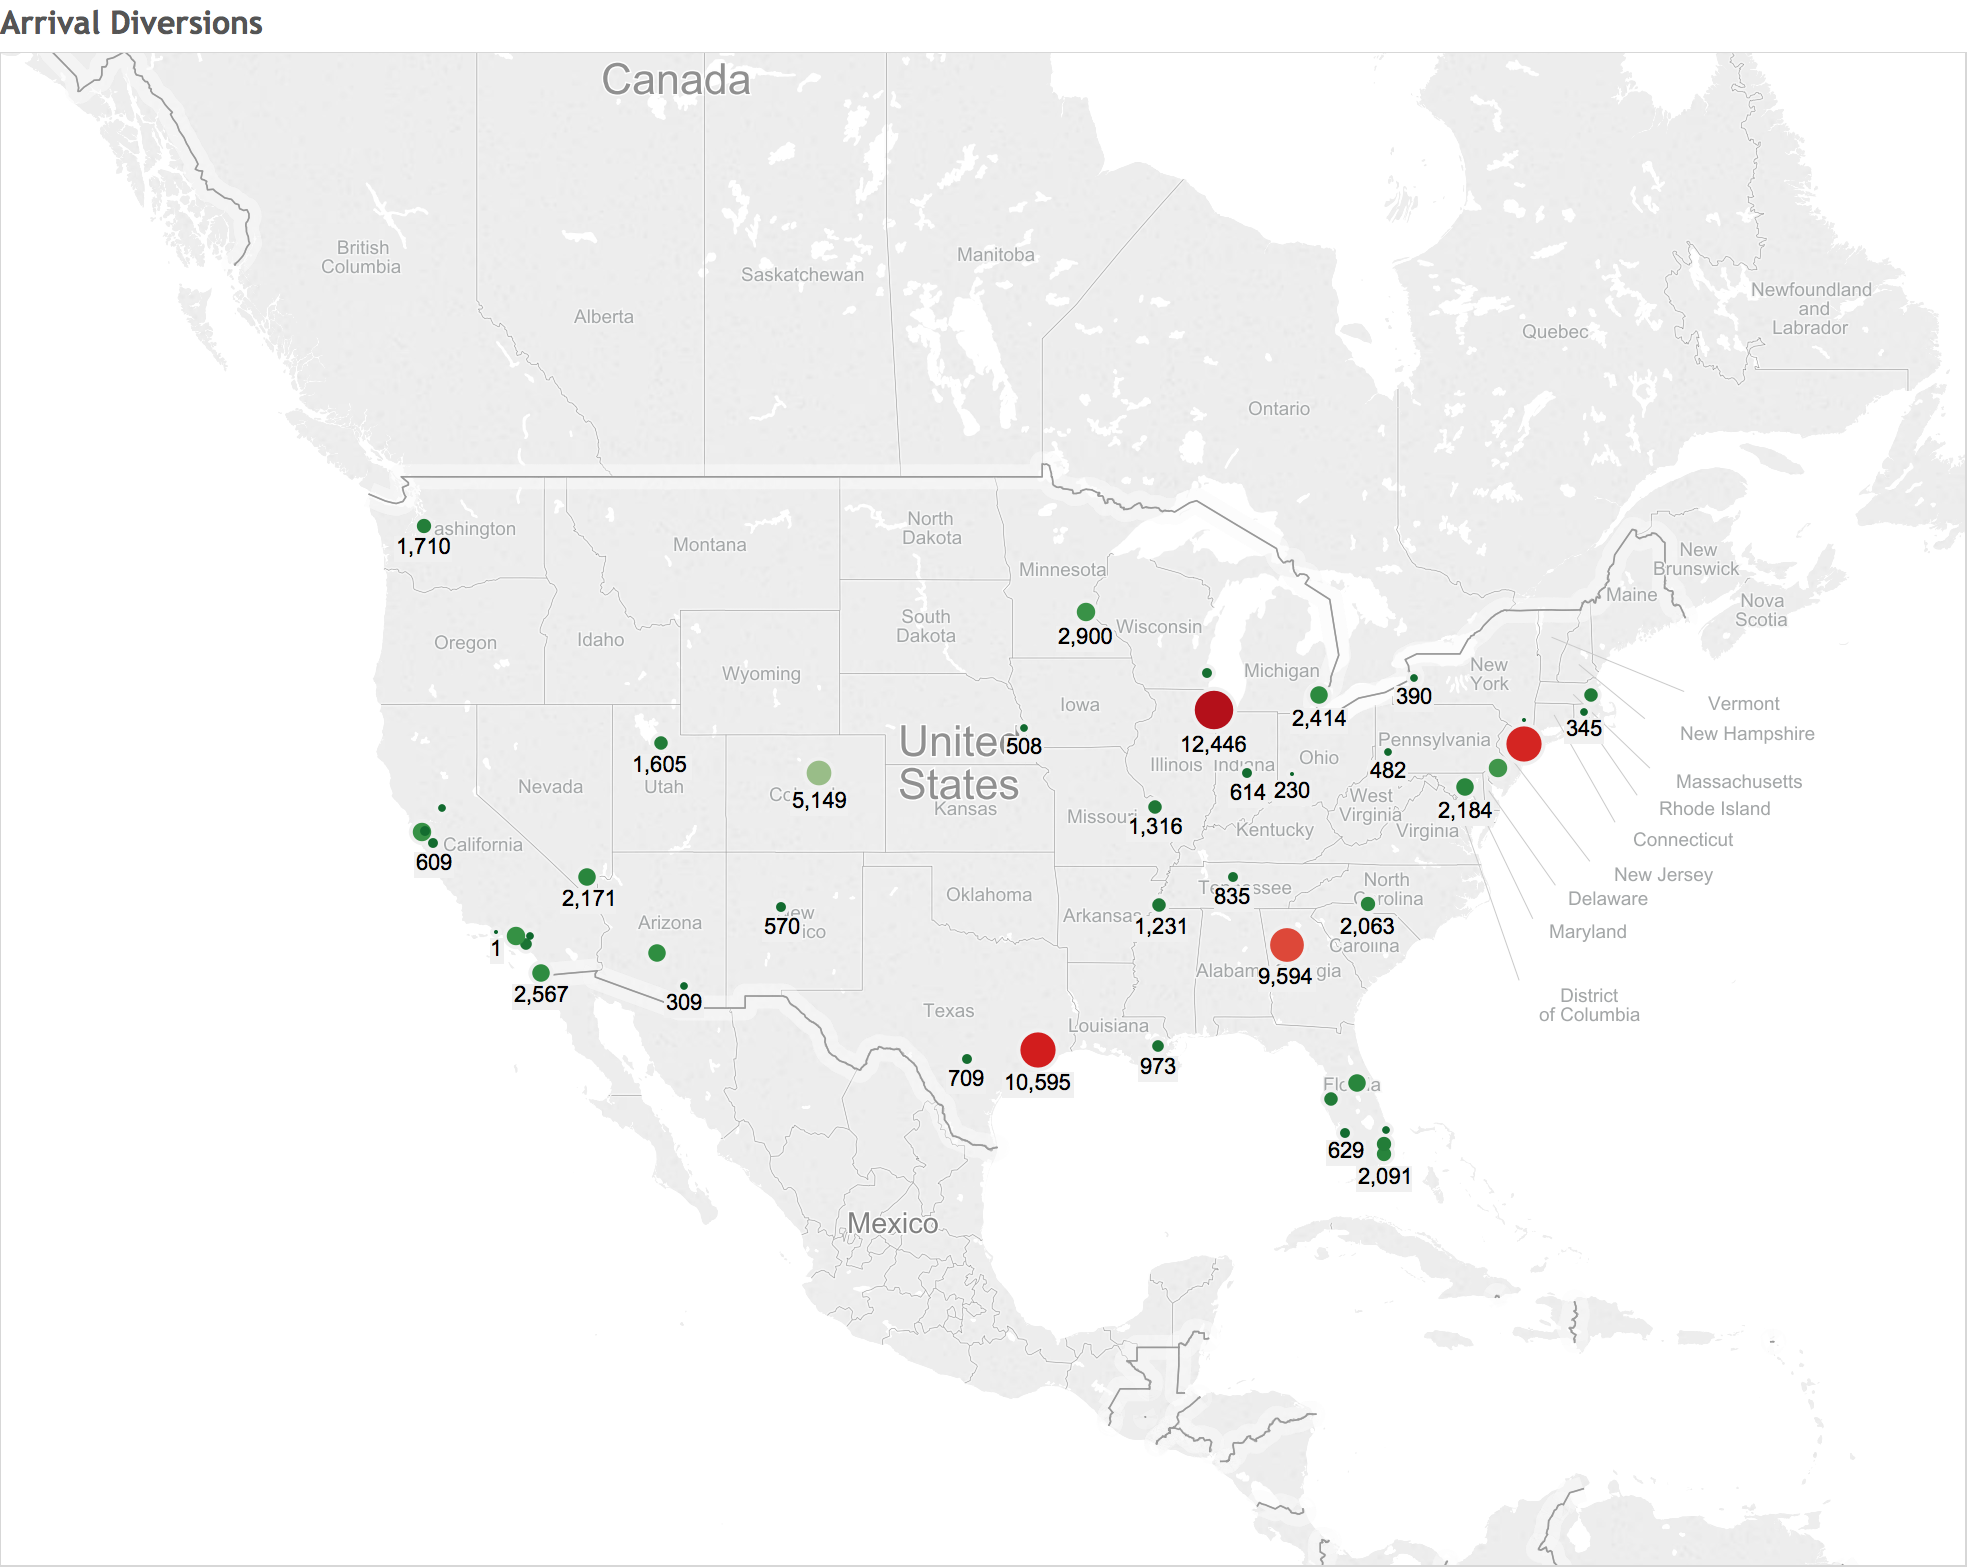

In [822]:
from IPython.display import Image
from IPython.display import display

#heatmap for rate
x = Image(filename='../assets/Departure Cancellations.png')

#heatmap for verbal
y = Image(filename='../assets/Departure Diversions.png')

#heatmap for math
z = Image(filename='../assets/Arrival Cancellations.png')

w = Image(filename='../assets/Arrival Diversions.png')

#display all the images
display(x)
display(y)
display(z)
display(w)

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps

In [823]:
stuff = pd.DataFrame(sklearn_pca.components_,columns=X.columns,index=['PCA-1','PCA-2'])
stuff.head()

,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
PCA-1,0.317420,0.380998,0.387162,0.417512,0.312399,0.296555,0.346146,0.352874
PCA-2,0.557048,-0.353076,-0.332898,0.238168,-0.185072,-0.384904,-0.012939,0.463595


First, Chicago O'Hare, Atlanta Hartsfield-Jackson, and Dallas/Fort Worth International airport had the most departure cancellations, departure diversions, arrival cancellations, and arrival diversions. Surprisingly, west coast doesn't suffer from too many cancellations and diversions despite having big cities such as Seattle, San Francisco, and Los Angeles. 
Second, the principal component 1 values from the data frame above tells us that airport departure delay, taxi out delay, and taxi out time are the most influential factors causing cancellations and diversions from the operations side. They need to focus reducing those delays first. Next things that FAA needs to focus on reducing gate departure delay and gate arrival delay as shown in principal componet 2 values.
One thing the FAA might want to investigate on is how LAX and SFO has such little cancellations and diversions considering the size and the business of the airport. They can learn from what they are doing and apply it in the same way to the "worst" airports such as Chicaco O'Hare, Atlanta Hartsfield-Jackson, and Dallas/Fort Worth airports. 

### Part 6: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied